# Comparison of **rSVD** and **SVD**

In this notebook, we will explore and compare the performance and results of the **randomized Singular Value Decomposition (rSVD)** and the **conventional Singular Value Decomposition (SVD)**.

## **Singular Value Decomposition (SVD)**

Singular Value Decomposition (SVD) is a fundamental matrix factorization technique used in **linear algebra** and **machine learning**. Given a matrix $ A $ of dimension $ m \times n $, the SVD decomposes $ A $ into three other matrices: $ U, \Sigma, $ and $ V^T $, where:

$ A = U \Sigma V^T $

- $ U $ is an $ m \times m $ orthogonal matrix,
- $ \Sigma $ is an $ m \times n $ diagonal matrix, and
- $ V^T $ is an $ n \times n $ orthogonal matrix.

The diagonal elements of $ \Sigma $ are the **singular values** of $ A $, and the columns of $ U $ and $ V $ are the **left** and **right singular vectors** of $ A $ respectively.

## **Randomized Singular Value Decomposition (rSVD)**

Randomized Singular Value Decomposition (rSVD) is a faster approximation to the conventional SVD. It's particularly useful when dealing with very **large matrices** where traditional SVD computation becomes computationally infeasible. The rSVD reduces the dimensionality of the original matrix by projecting it onto a **lower-dimensional random subspace**, preserving the most significant singular values and vectors with high probability.

Mathematically, the rSVD also seeks to decompose the original matrix $ A $ into three matrices $ U, \Sigma, $ and $ V^T $, but it does so by working with a smaller matrix obtained through **random projection**, which accelerates the decomposition process.

$ A \approx U \Sigma V^T $

Here, the approximation symbol $ \approx $ indicates that the decomposition obtained through rSVD is an approximation to the exact decomposition obtained through traditional SVD.

## **Objective**

In this notebook, we will implement and compare the SVD and rSVD algorithms on a sample matrix. We will measure the **accuracy of the decomposition** and the **time taken** by each algorithm to complete the decomposition. Through this comparison, we aim to understand the **trade-offs** between accuracy and computational efficiency offered by rSVD and SVD.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from skimage import io
from sklearn.utils.extmath import randomized_svd  # Importing randomized_svd from scikit-learn
import time


# Reading and converting the image to grayscale
Ao = io.imread('../../data/nature.jpg')
A = color.rgb2gray(Ao)
A = A.T  # Transposing A to match the MATLAB version



In [7]:
r = 500  # Target rank

svd_time=time.time()
# Deterministic SVD
U, S, Vt = np.linalg.svd(A, full_matrices=False)
svd_process_time=time.time()-svd_time
print(f'SVD processing time in second has taken : {time.time()-svd_time}')

# Reconstruction
ASVD = U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]
eSVD = np.linalg.norm(A - ASVD, 2) / np.linalg.norm(A, 2)
print(f'Error SVD={eSVD}')

SVD processing time in second has taken : 3.645854949951172
Error SVD=0.000548972178246707


In [8]:
# Parameters for Randomized SVD
q = 5   # Number of power iterations
p = 100 # Oversampling parameter

rsvd_time=time.time()
# Randomized SVD using scikit-learn's randomized_svd function
rU, rS, rV = randomized_svd(A, n_components=r, n_oversamples=p-r, n_iter=q)
rsvd_process_time=time.time()-rsvd_time
print(f'rSVD processing time in second has taken : {time.time()-rsvd_time}')

# SVD approximations
ArSVD = rU[:, :r] @ np.diag(rS[:r]) @ rV[:r, :]  # rSVD approximation using rsvd library
erSVD = np.linalg.norm(A - ArSVD, 2) / np.linalg.norm(A, 2)
print(f'Error random SVD={erSVD}')


rSVD processing time in second has taken : 0.5646543502807617
Error random SVD=0.005060107198870543


## Creating a table for better comparison:

In [9]:
import pandas as pd

# Create a dictionary to hold the data
data = {
    'Metric': ['Processing Time (seconds)', 'Error Value'],
    'SVD': [svd_process_time, eSVD],
    'rSVD': [rsvd_process_time, erSVD]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the Metric column as the index
df.set_index('Metric', inplace=True)

# Display the DataFrame
print(df)


                                SVD      rSVD
Metric                                       
Processing Time (seconds)  3.645855  0.564654
Error Value                0.000549  0.005060


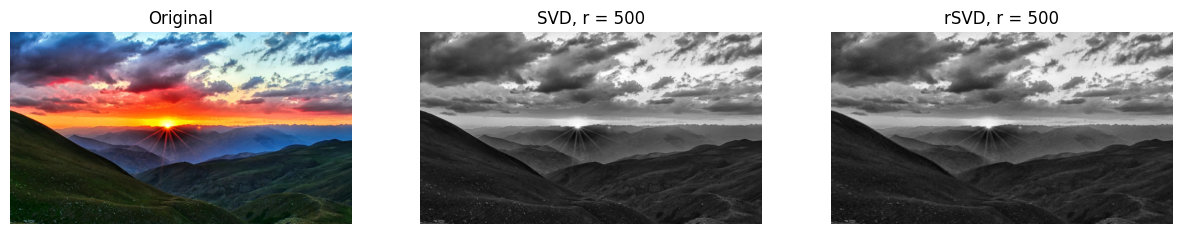

In [10]:

# Plotting
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(Ao, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ASVD.T, cmap='gray')
plt.title(f'SVD, r = {r}')
plt.ylabel(f'Err={eSVD}')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(ArSVD.T, cmap='gray')
plt.title(f'rSVD, r = {r}')
plt.xlabel(f'Err={erSVD}')
plt.axis('off')

plt.show()

## How rSVD works and how we achieve it:

The Randomized Power Method for SVD iteratively refines an orthonormal matrix $ Q $ to approximate the range of $ A $ or $ A^TA $, depending on the case. The power iterations play a role in step 2 and 3 of the process. Here's the breakdown with the math involved:

1. **Step 1: Randomized Range Finder**:
    - Generate a random matrix $ \Omega $ with size $ n \times (k+p) $ where $ k $ is the target rank and $ p $ is the oversampling parameter.
    - Form the matrix product $ Y = A \Omega $.
    - Perform QR decomposition on $ Y $ to obtain $ Q $ such that $ Y = QR $.

2. **Step 2: Iteration (Power Iterations)**:
    - For $ i = 1, 2, \ldots, q $ (where $ q $ is the number of power iterations):
        - Update $ Y $ by setting $ Y = A^TA Y $ or alternately $ Y = A A^T Y $.
        - Perform QR decomposition on $ Y $ to re-orthonormalize, obtaining an updated $ Q $.

    Mathematically, the iterative step can be expressed as:

    $ Y \leftarrow A^T A Y \quad \text{ or } \quad Y \leftarrow A A^T Y $

    $ Q, R \leftarrow \text{QR}(Y) $

    The QR decomposition in each iteration ensures that the columns of $ Q $ remain orthonormal, and the multiplication with $ A^TA $ or $ A A^T $ refines $ Q $ to better approximate the range of $ A $.

3. **Step 3: Form the Core Matrix**:
    - Compute the matrix $ B = Q^T A $.

4. **Step 4: Standard SVD on Core Matrix**:
    - Perform a standard SVD on $ B $ to obtain $ U_B, \Sigma, V^T $ such that $ B = U_B \Sigma V^T $.

5. **Step 5: Retrieve the Left Singular Vectors**:
    - Compute the left singular vectors of $ A $ by setting $ U = Q U_B $.

In this method, the power iterations in step 2 help to refine the orthonormal matrix $ Q $ such that it better approximates the range of $ A $, which in turn improves the accuracy of the resulting singular vectors and singular values obtained in steps 4 and 5.



## Effect of Power Iteration:

In the Randomized Power Method for SVD, the iteration step is crucial for honing in on more accurate singular vectors. The essence of the iteration step is to repeatedly apply the matrix $ A^T A $ to the matrix $ Y $, which enhances the alignment of the columns of $ Y $ with the principal singular vectors of $ A $.

Here's a bit more detail:

1. **Iteration Process**:
    - Initially, matrix $ Y $ is obtained from some random starting vectors. 
    - In each iteration, you multiply $ Y $ by $ A^T A $ to get a new $ Y $, i.e., $ Y = A^T A Y $.
    - This multiplication tends to stretch $ Y $ in the direction of the leading singular vectors of $ A $, because $ A^T A $ is a symmetric positive semi-definite matrix, and its action on any vector (or set of vectors, as in $ Y $) tends to stretch them in the direction of its eigenvectors corresponding to the largest eigenvalues. 
    - In the context of SVD, the eigenvectors of $ A^T A $ correspond to the right singular vectors of $ A $, and the eigenvalues of $ A^T A $ correspond to the squares of the singular values of $ A $.

2. **Size and Area**:
    - The dimensions of $ Y $ remain the same, $ n \times (k+p) $, throughout the iteration process.
    - The "area" in the matrix space that $ Y $ occupies gets progressively aligned with the principal singular vectors of $ A $ with each iteration.

3. **Enhanced Quality**:
    - Each iteration step enhances the quality of the approximation to the singular vectors.
    - The power iteration method amplifies the presence of the principal singular vectors in $ Y $ while diminishing the presence of the other, less significant singular vectors.
    - Over iterations, this process sharpens the approximation of the principal singular vectors, which in turn improves the quality of the derived singular value decomposition.